In [1]:
#Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns
from collections import defaultdict

#Extra Visualization and stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS

#Evaluation Metrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#Spell Checker
from spellchecker import SpellChecker

#Rid of warnings
import warnings
warnings.filterwarnings("ignore")

#Preprocessing
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.svm import SVC
# Import Pipeline and GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## NLP Project:
    Disaster Tweets Identification 
An NLP classification project. Using machine learning, I created models to identify text-based tweets that talks about real disaster from a mixture of tweets with varying topics. Our priority will be on the target variable which is disaster tweets. Additionally, we want to identify words that are strong predictors for our model.
    The format that will be sent to Kaggle for scoring is below:

In [2]:
sample = pd.read_csv("datasets/sample_submission.csv")
sample.head(3)

,id,target
0,0,0
1,2,0
2,3,0


---

In [3]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [4]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [5]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [6]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


### DATA CLEANING / EDA

In [7]:
train.target.value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

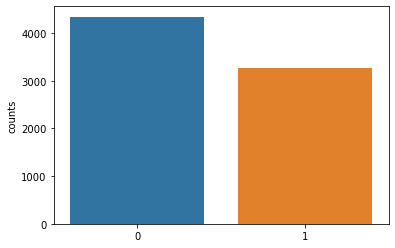

In [8]:
x = train.target.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('counts');

There are more non-disaster Tweets than real disaster tweets.

In [9]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [10]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [11]:
train.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [12]:
train.location.value_counts()

USA                     104
New York                 71
United States            50
London                   45
Canada                   29
                       ... 
fluffy cloud              1
Brooklyn                  1
Norman, Oklahoma          1
Wilmington, Delaware      1
Sutton, London UK         1
Name: location, Length: 3341, dtype: int64

#### Impact of Location and Keywords

In [13]:
train.location.value_counts().value_counts()
# 2818 locations only shown up once NOTE: could be problematic as a predictor

1      2818
2       266
3       100
4        50
5        31
6        18
9         8
7         8
10        7
11        4
13        3
15        3
12        3
8         3
14        3
18        2
24        1
20        1
22        1
71        1
26        1
28        1
50        1
45        1
17        1
19        1
21        1
27        1
29        1
104       1
Name: location, dtype: int64

location will most likely not be used as a feature due to the large variety of places. 

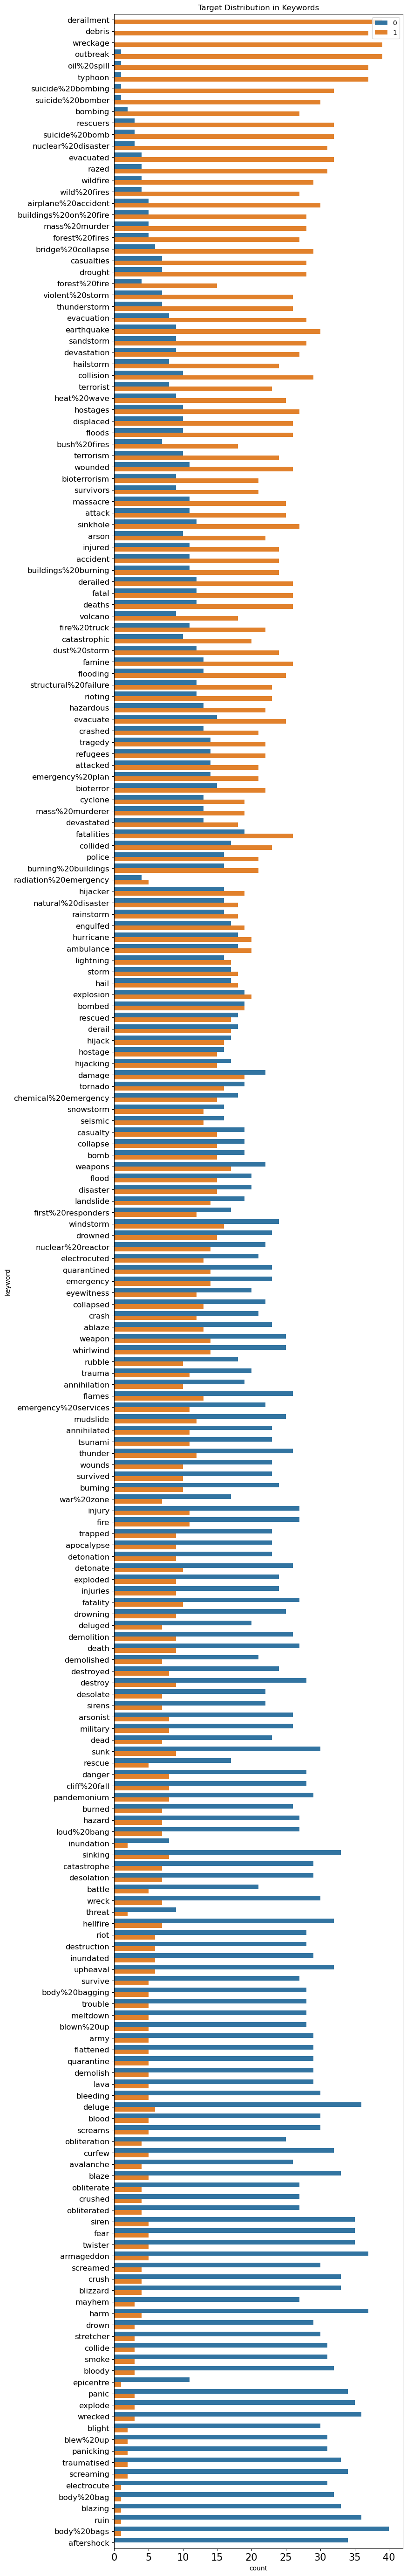

In [14]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True);

Keysword have a huge range of impacts. Some keywords are common within both tweets (is not a good predictor), but some are also clear indications that the tweet is talking about real disaster (or not a disaster).

Note: derailment, debris, and wreckage are keywords used only in real disaster tweets, and aftershock is not contained within ay real tweet. Additionally, these words occur often.

##### Text

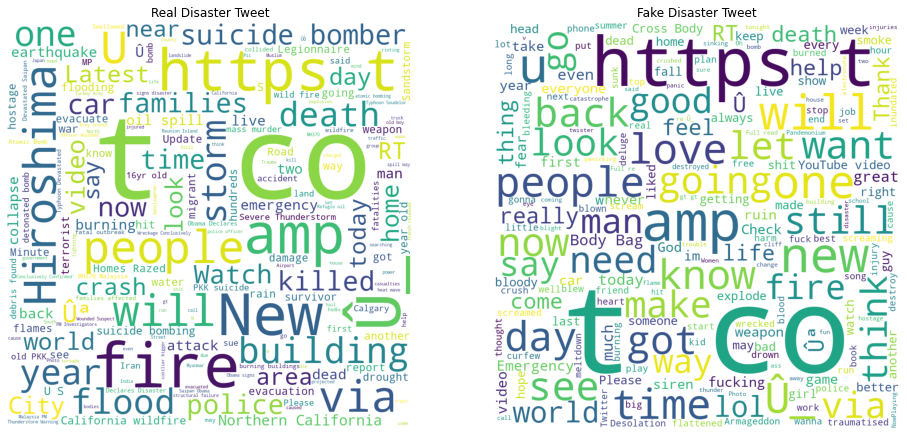

In [15]:
fig , ax = plt.subplots(1, 2, figsize=(16,32))
wordcloud_True = WordCloud(background_color='white',width=800, height=800).generate(' '.join(train[train['target'] == 1]['text']))
wordcloud_False = WordCloud(background_color='white',width=800, height=800).generate(' '.join(train[train['target'] == 0]['text'])) 
ax[0].imshow(wordcloud_True)
ax[0].axis('off')
ax[0].set_title('Real Disaster Tweet')
ax[1].imshow(wordcloud_False)
ax[1].axis('off')
ax[1].set_title('Fake Disaster Tweet')
plt.show()

Note that a lot of tweets from both tweets contain some website link.

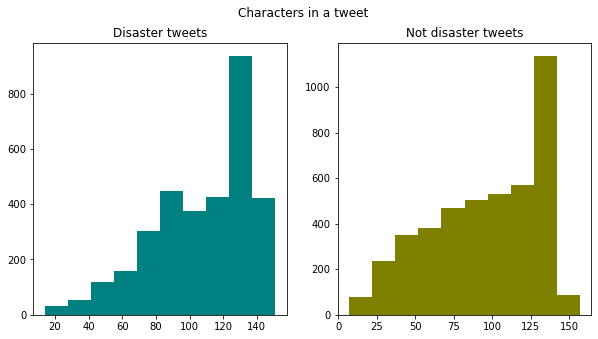

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=train[train['target']==1]['text'].str.len()
ax1.hist(text_len,color='teal')
ax1.set_title('Disaster tweets')
text_len=train[train['target']==0]['text'].str.len()
ax2.hist(text_len,color='olive')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in a tweet')
plt.show();

The distributions of the characters are nearly the same. Note that 120 to 140 characters in tweets are common in both. This indicate that the length of the tweet won't help to determine our outcome 

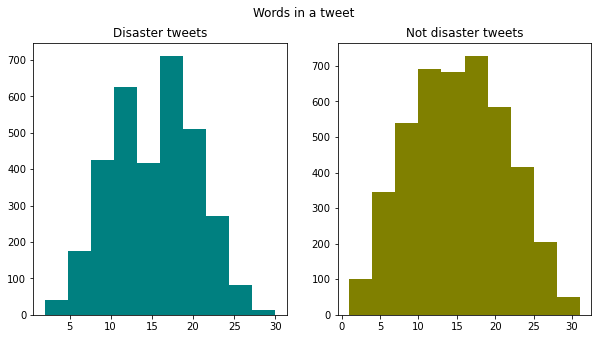

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='teal')
ax1.set_title('Disaster tweets')
text_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='olive')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

The distribution of the number of words in a tweet is similar in both types of tweets. They both follow a bell curve and peak and aroud 13 to 18 words per tweet. 

We want to see the common word/words that are in disaster and non disaster tweets:

In [18]:
#return a list that from a string and exclude the stopwords
def generate_ngrams(text, n_gram=1):
    table=str.maketrans('','',string.punctuation)
    text = text.translate(table)
    text = re.sub("[^a-zA-Z]", " ", text) #Replace none letters with space
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [19]:
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[train['target'] != 1]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

In [20]:
disaster_unigrams = {}
disaster_unigrams['deeds'] = 1

In [21]:
disaster_unigrams['deeds'] += 1

In [22]:
disaster_unigrams

{'deeds': 2}

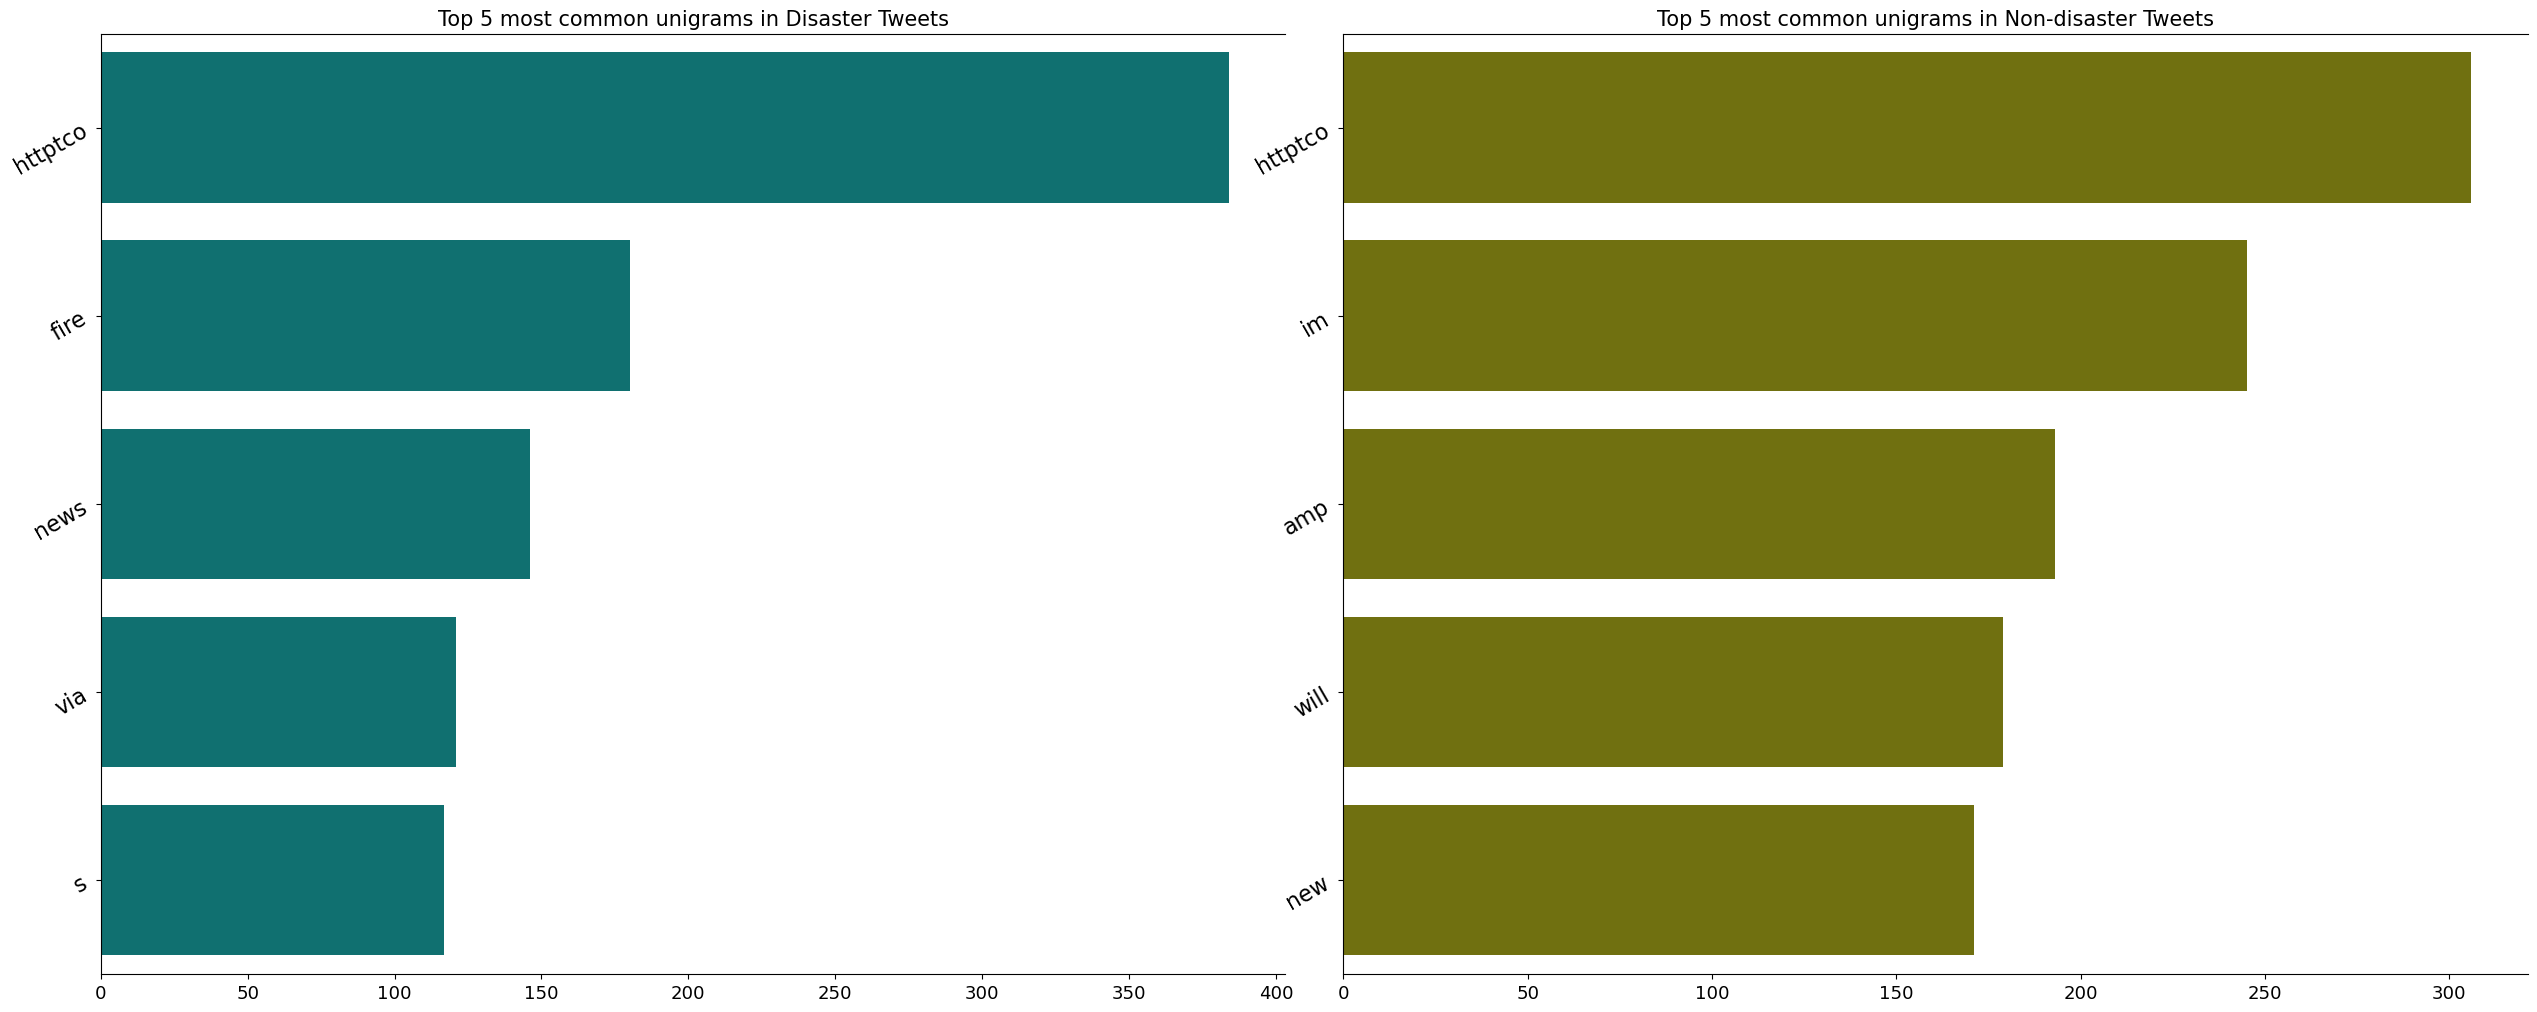

In [134]:
N = 5

fig, axes = plt.subplots(ncols=2, figsize=(25, 10), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='teal')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='olive')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=16, rotation=30)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

We see a lot of letters that are not formed into words. From this we also conclude that http, com, co, and all other indication of a website should be remove as they occur regularly in both types of tweets. As usual, stop words will be removed as well. However, they will be used to create new features which may increase the over all performance of the models

In [24]:
#Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[train['target'] != 1]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

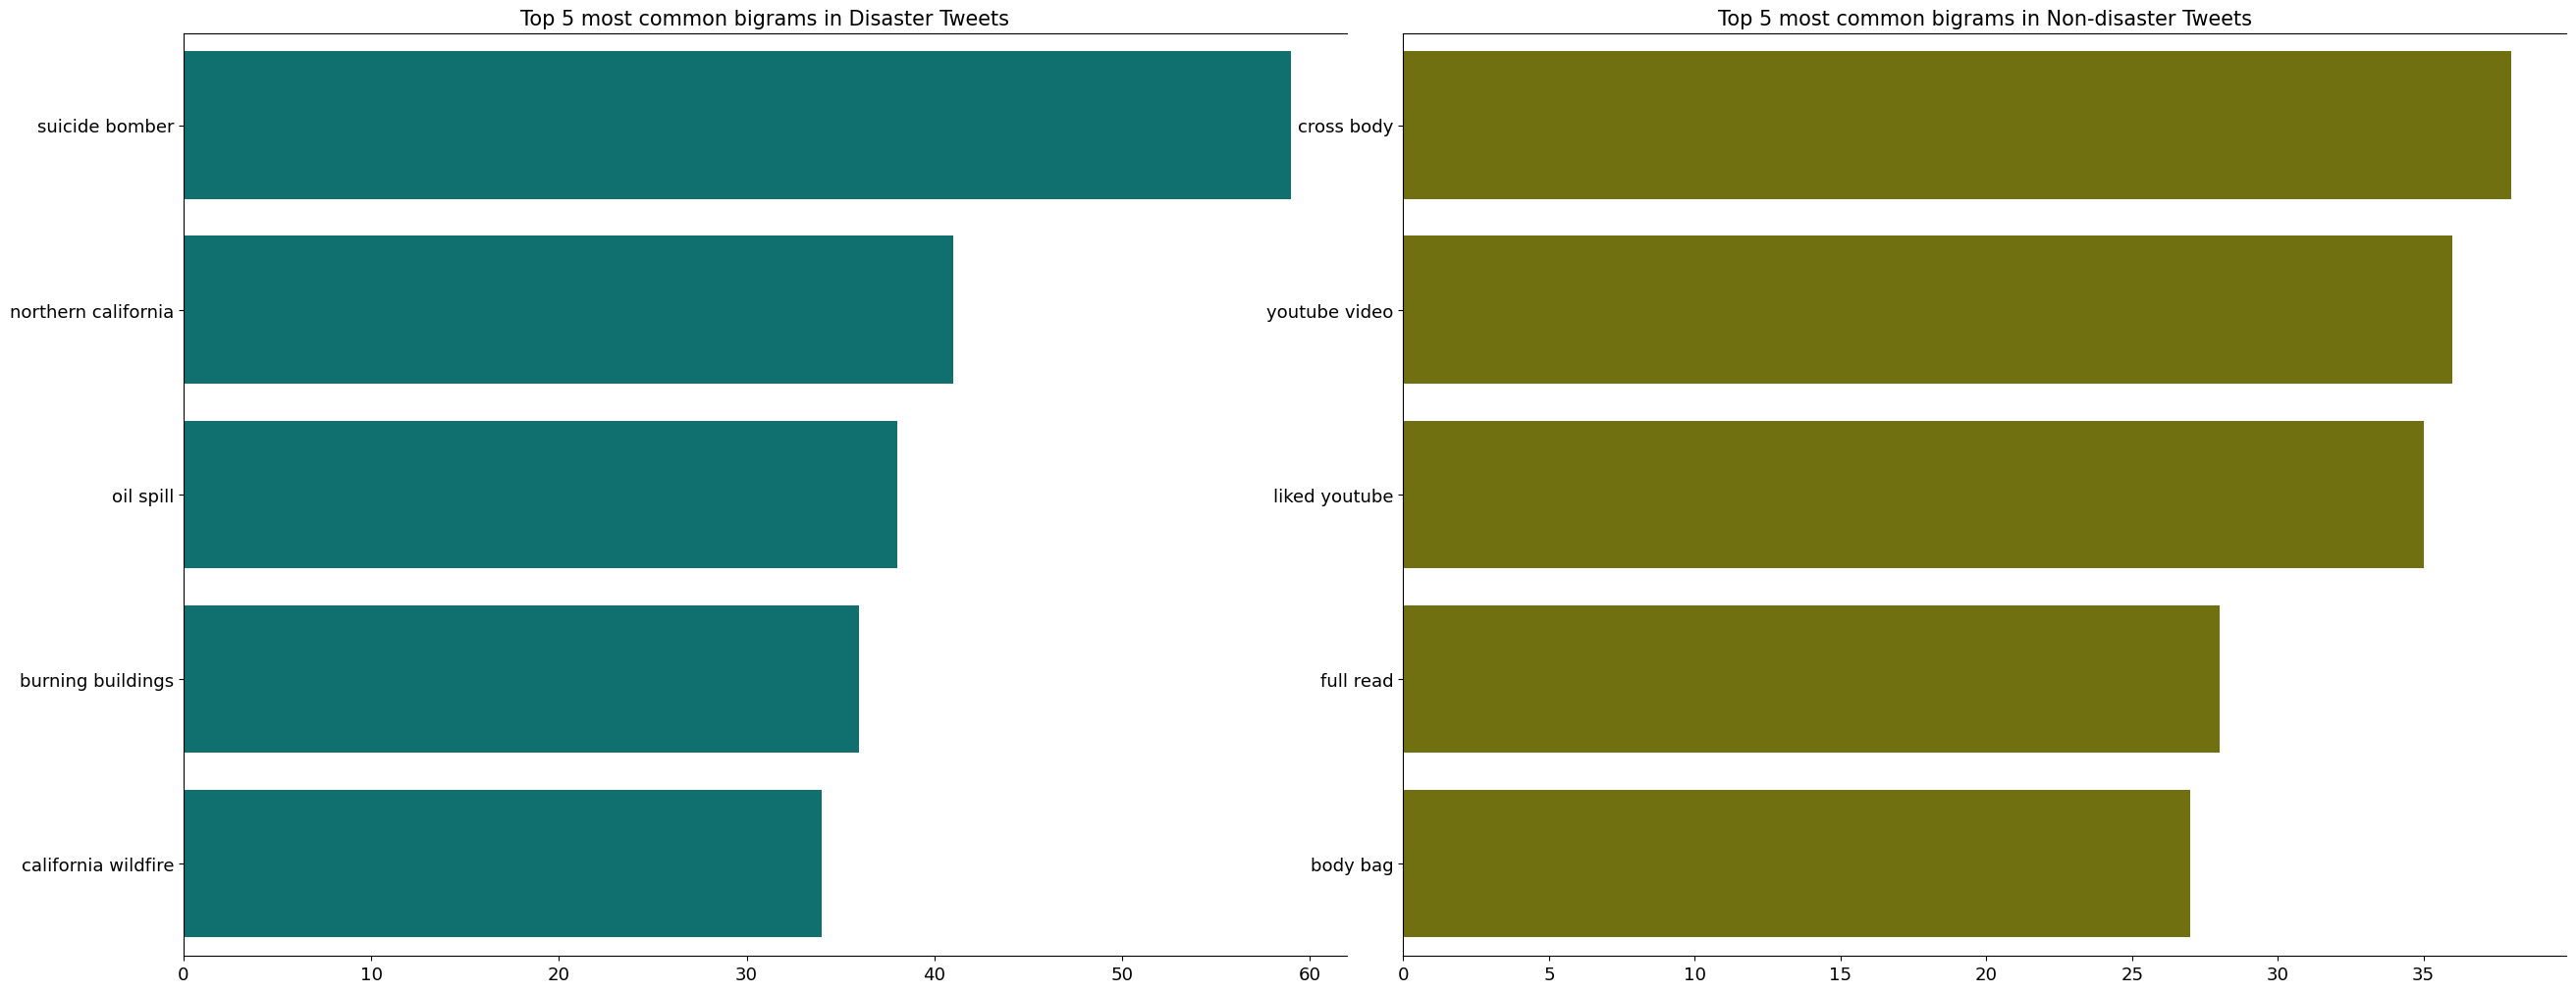

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 10), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='teal')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='olive')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

With bigram, we have a clearer picture of what words occurs often in non disaster treet but not on real disaster tweets. This will help us when optimising our model

In [26]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[train['target'] == 1]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[train['target'] != 1]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

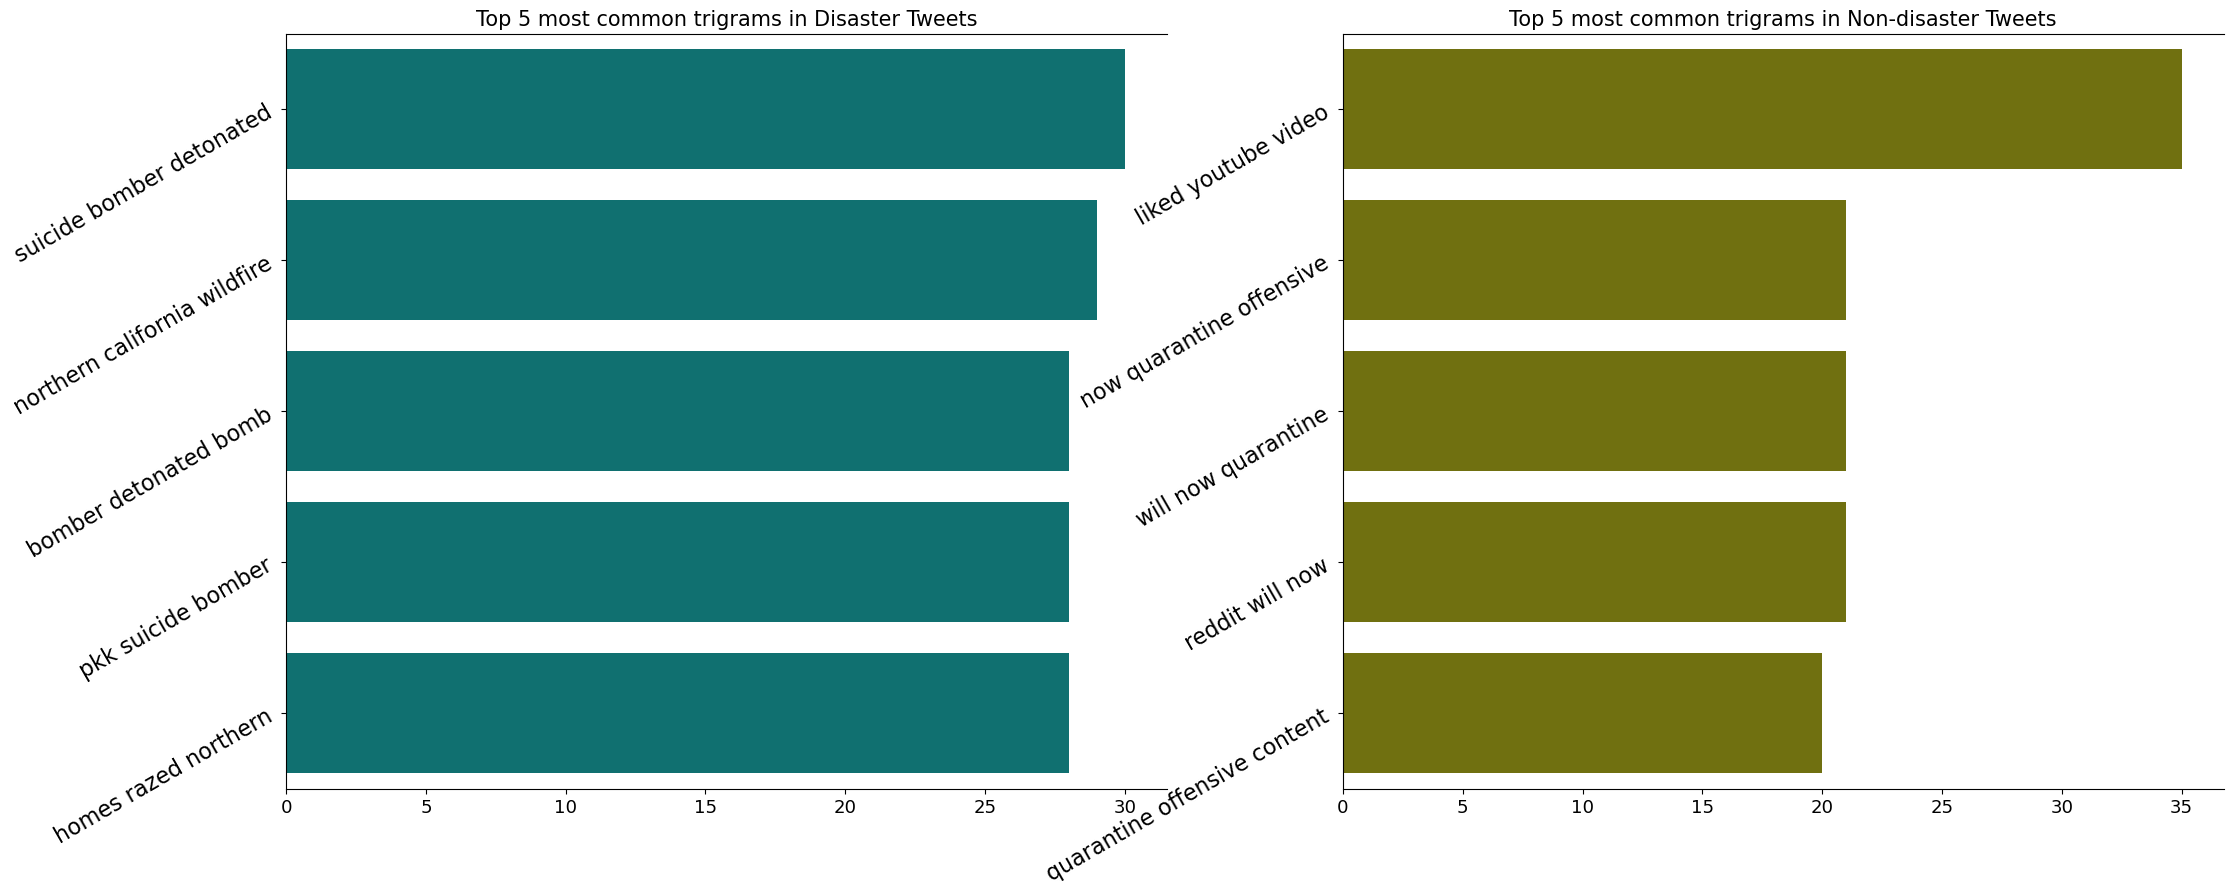

In [133]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 10), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='teal')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='olive')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=16, rotation=30)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

Trigrams definitly shows a huge different between the phrases used in each tweet types. It can be safely assume that trigram will perform better than unigram and bigrams when optimizing the model.

### Feature Engineering

In [28]:
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

In [29]:
# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

In [30]:
# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [31]:
# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [32]:
# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [33]:
# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

In [34]:
# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [35]:
# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [36]:
# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [37]:
train.shape

(7613, 14)

In [38]:
train.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0


---

### Text Preprocessing

In [39]:
df=pd.concat([train,test])
df.shape

(10876, 14)

Removing URL

In [40]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [41]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

Removing HTML Tags

In [42]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [43]:
df['text']=df['text'].apply(lambda x : remove_html(x))

Removing Emojis

In [44]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [45]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

Removing Punctuations

In [46]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [47]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

Spelling Corrections

In [48]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [49]:
correct_spellings("Hi I'm new here welcom")

"Hi I'm new here welcome"

The code block below takes a while to run as it loops through every word in every tweet and see if they are misspelled.

The new df will be exported and imported again so we would not have to re run this code block every time we run.

In [50]:
new_df = pd.read_csv("datasets/correct_text_df")

In [51]:
new_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,13,13,6,0,4.384615,69,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,7,7,0,0,4.571429,38,1,0,0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,22,20,11,0,5.090909,133,3,0,0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,8,8,1,0,7.125000,65,2,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,16,15,7,0,4.500000,88,2,2,0


In [52]:
new_df.fillna('none', inplace=True)

---

In [53]:
train = new_df[new_df['target']!='none']

In [54]:
train.head(3)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,1,none,none,Our Deeds are the Reason of this earthquake Ma...,1,13,13,6,0,4.384615,69,1,1,0
1,4,none,none,Forest fire near La Ronge Sask Canada,1,7,7,0,0,4.571429,38,1,0,0
2,5,none,none,All residents asked to shelter in place are be...,1,22,20,11,0,5.090909,133,3,0,0


In [55]:
train.shape

(7613, 14)

In [56]:
test = new_df[new_df['target']=='none']
test.reset_index(drop=True, inplace=True)

In [57]:
test.head(3)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,0,none,none,Just happened a terrible car crash,none,6,6,2,0,4.833333,34,0,0,0
1,2,none,none,Heard about earthquake is different cities sta...,none,9,9,2,0,6.222222,64,3,1,0
2,3,none,none,there is a forest fire at spot pond geese are ...,none,19,19,10,0,4.105263,96,2,0,0


In [58]:
test.drop('target', axis=1, inplace=True)

In [59]:
test.shape

(3263, 13)

Splitting the train data to create and evaluate our model

In [60]:
feature = [i for i in train.columns if (i != 'target') & (i != 'id')]
X = train[feature]
y = train['target']

In [61]:
X.shape

(7613, 12)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [63]:
y_test.value_counts(normalize=True) #baseline

0.0    0.570378
1.0    0.429622
Name: target, dtype: float64

In [64]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
lemmatizer = WordNetLemmatizer()

In [65]:
def simplify_words(text):
    
    letters_only = re.sub("[^a-zA-Z]", " ", text) #Replace none letters with space
    temp_tokens = tokenizer.tokenize(letters_only) #Put in list (tokenize)
    lem_temp = [lemmatizer.lemmatize(i) for i in temp_tokens] #lemmatize
    result = [word.lower() for word in lem_temp]
    return(" ".join(result)) #return back a string (will be used with .map/.apply)

In [66]:
X_train.text[6]

'flood disaster Heavy rain causes flash flooding of streets in Manitou Colorado Springs areas'

In [67]:
simplify_words(X_train.text[6])

'flood disaster heavy rain cause flash flooding of street in manitou colorado springs area'

In [68]:
total_tweets = train.shape[0]
print(f'There are {total_tweets} tweets.')

There are 7613 tweets.


We want to include keyword as another feature. Since it's categorical, we must hot-encode them. However, since we are already vectorizing them. It's most efficient to include them as another additional word.

In [69]:
X_train.keyword = X_train['keyword'].apply(lambda x: x if x != 'none' else '')
X_test.keyword = X_test['keyword'].apply(lambda x: x if x != 'none' else '')
X_train.text = X_train['text'] + ' ' + X_train['keyword']
X_test.text = X_test['text'] + ' ' + X_test['keyword']

In [70]:
X_train.text = X_train['text'].apply(lambda x: simplify_words(x))
X_test.text = X_test['text'].apply(lambda x: simplify_words(x))

In [71]:
cvec = CountVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features = 5000,
                           min_df = 2,
                           max_df = .8,
                           ngram_range = (1,3),
                           binary = False
                           )

In [72]:
test.keyword = test.keyword.apply(lambda x: x if x != 'none' else '')
test.text = test['text'].apply(lambda x: simplify_words(x))

15,000 words/features without limiting to 5000. Additionally once the numbe rof features used exceed 5000, a lot of words becoming less impactful and create inaccuracies.

In [73]:
train_vec = cvec.fit_transform(X_train.text)
test_vec = cvec.transform(X_test.text)

In [74]:
test_id = test.id
test.drop(inplace=True, columns='id')

In [75]:
kaggle_vec = cvec.transform(test.text)

In [76]:
features_vec = cvec.get_feature_names()

In [77]:
train_vec = train_vec.toarray()
test_vec = test_vec.toarray()

In [78]:
kaggle_vec = kaggle_vec.toarray()

In [79]:
train_df = pd.DataFrame(columns=features_vec, data=train_vec)
test_df = pd.DataFrame(columns=features_vec, data=test_vec)

In [80]:
kaggle_df = pd.DataFrame(columns=features_vec, data=kaggle_vec)

In [81]:
X_train.shape

(5709, 12)

In [82]:
train_df.shape

(5709, 5000)

In [83]:
train_df

,aba,aba as,aba as woman,abandoned,abandoned aircraft,abc,abc news,abc news razed,ablaze,ablaze ablaze,...,youtube playlist,youtube video,youtube video from,youve,yr,yr old,yr old pkk,zone,zone war,zone war zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5706,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
X_train

,index,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
0,5360,panic,none,drake spoke rep for the raptorsbeg to differ t...,24,23,12,0,4.583333,133,3,0,0
1,1500,catastrophic,none,catastrophicfallenangel reveillertm macabrelol...,14,13,5,1,8.714286,135,13,0,0
2,5086,nuclear%20disaster,none,though serious natural disaster increased in j...,17,17,3,0,7.000000,135,8,7,0
3,3212,emergency%20services,none,were hiring click to apply rn iiemergency serv...,14,14,2,2,8.571429,133,21,3,0
4,6706,thunder,none,i love the sound of thunder rumbling across th...,10,9,4,0,4.900000,58,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,2522,desolation,infj,going to redo my nail and watch behind the sce...,15,14,6,0,4.266667,78,0,0,0
5705,2373,derail,none,bbc news india rail crash trains derail in mad...,14,14,1,1,5.857143,95,7,0,0
5706,305,armageddon,"California, United States",pbban temporary russaky armageddon do not kill...,16,14,4,0,4.937500,94,10,1,1
5707,1648,collapsed,USA,petition heartless owner that whipped horse un...,20,20,7,1,5.450000,128,8,0,0


In [85]:
test.reset_index(inplace=True)

In [86]:
X_train = pd.concat([X_train,train_df], axis=1)
X_test = pd.concat([X_test,test_df], axis=1)

In [87]:
test = pd.concat([test, kaggle_df], axis=1)

In [88]:
X_train.drop(['keyword', 'location', 'text', 'index'], axis=1, inplace=True)
X_test.drop(['keyword', 'location', 'text', 'index'], axis=1, inplace=True)

In [89]:
test.drop(['keyword', 'location', 'text', 'index'], axis=1, inplace=True)

Both X_train and X_test now have all the features that will be used for creating our model

In [90]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [91]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

### Modeling

In [92]:
X_train

,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,aba,...,youtube playlist,youtube video,youtube video from,youve,yr,yr old,yr old pkk,zone,zone war,zone war zone
0,24,23,12,0,4.583333,133,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14,13,5,1,8.714286,135,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,17,3,0,7.000000,135,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,14,2,2,8.571429,133,21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,9,4,0,4.900000,58,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,15,14,6,0,4.266667,78,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5705,14,14,1,1,5.857143,95,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5706,16,14,4,0,4.937500,94,10,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5707,20,20,7,1,5.450000,128,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will also use SVM as they are great for 2-class classifications

Logistic Regression

In [93]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Accuracy on Train Data:', lr.score(X_train, y_train))
print('Accuracy on Test Data:', lr.score(X_test, y_test))
lr_pred = lr.predict(X_test)

Accuracy on Train Data: 0.8232615169031354
Accuracy on Test Data: 0.7909663865546218


Multinomial Naive Bayes

In [94]:
mb = MultinomialNB()
mb.fit(X_train, y_train)
print('Accuracy on Train Data:', mb.score(X_train, y_train))
print('Accuracy on Test Data:', mb.score(X_test, y_test))
mb_pred = mb.predict(X_test)

Accuracy on Train Data: 0.8299176738483097
Accuracy on Test Data: 0.7967436974789915


Bernoulli Naive Bayes

In [95]:
bb = BernoulliNB()
bb.fit(X_train, y_train)
print('Accuracy on Train Data:', bb.score(X_train, y_train))
print('Accuracy on Test Data:', bb.score(X_test, y_test))
bb_pred = bb.predict(X_test)

Accuracy on Train Data: 0.8244876510772464
Accuracy on Test Data: 0.8040966386554622


SVM

SVM end up not being very usefull for nlp and takes a long time to process so it'll be removed

### Evaluation

In [96]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [97]:
def Confusion_Metrix(y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec,4)}')
    
    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens,4)}')
    
    print('Correctly Predict Target (Disaster) (TP):', tp)
    print('Correctly Predict non-Target (TN):', tn)
    print('Incorrectly Predict that the post is Target (Disaster) (FP):', fp)
    print('Incorrectly Predict that the post is non-Target (FN):', fn)

Specificity: 0.8306
Sensitivity: 0.7384
Correctly Predict Target (Disaster) (TP): 604
Correctly Predict non-Target (TN): 902
Incorrectly Predict that the post is Target (Disaster) (FP): 184
Incorrectly Predict that the post is non-Target (FN): 214


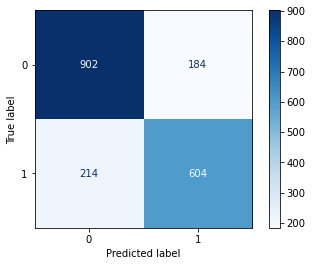

In [98]:
Confusion_Metrix(lr_pred)
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues');

Specificity: 0.8849
Sensitivity: 0.6797
Correctly Predict Target (Disaster) (TP): 556
Correctly Predict non-Target (TN): 961
Incorrectly Predict that the post is Target (Disaster) (FP): 125
Incorrectly Predict that the post is non-Target (FN): 262


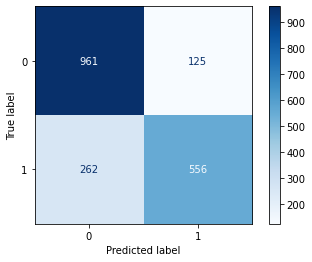

In [99]:
Confusion_Metrix(mb_pred)
plot_confusion_matrix(mb, X_test, y_test, cmap='Blues');

Specificity: 0.9567
Sensitivity: 0.6015
Correctly Predict Target (Disaster) (TP): 492
Correctly Predict non-Target (TN): 1039
Incorrectly Predict that the post is Target (Disaster) (FP): 47
Incorrectly Predict that the post is non-Target (FN): 326


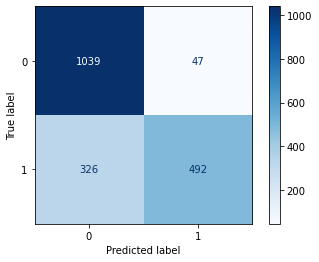

In [100]:
Confusion_Metrix(bb_pred)
plot_confusion_matrix(bb, X_test, y_test, cmap='Blues');

Despite all the models performing at around 80% accuracy, each model have different strength. From our evaluation, logistic regression is able to locate more of the target variable thna the other models. In our case, logistic model best help solves our problem, which is to identify disaster tweets among tweets with varying topics.

### Product model: Logistic Regression

In [101]:
predictor_df = pd.DataFrame(data={'Coef':lr.coef_[0], 'Col': X_train.columns})

In [102]:
predictor_df.sort_values(by='Coef').head(10)

,Coef,Col
2853,-1.033948,new
4947,-0.995344,you
578,-0.911021,body
407,-0.846479,bag
2784,-0.828496,my
1610,-0.768900,full
579,-0.655794,body bag
4540,-0.629120,upheaval
1797,-0.597413,harm
2508,-0.585143,love


Top Indicators of Non-Target Tweets: New, You, Body, Bag, My, Full, etc.

In [103]:
predictor_df.sort_values(by='Coef', ascending=False).head(10)

,Coef,Col
3908,1.099490,suicide
3869,1.055676,storm
4794,0.957763,wildfire
1897,0.941106,hiroshima
598,0.933623,bombing
1450,0.827271,fire
4407,0.820736,train
1244,0.819687,earthquake
703,0.791576,california
66,0.765202,after


Top Indicators of Disaster Tweets: Suicide, Storm, Wildfire, Hiroshima, Bombing, Fire, etc.

In [104]:
non_target = predictor_df.sort_values(by='Coef').head(10)

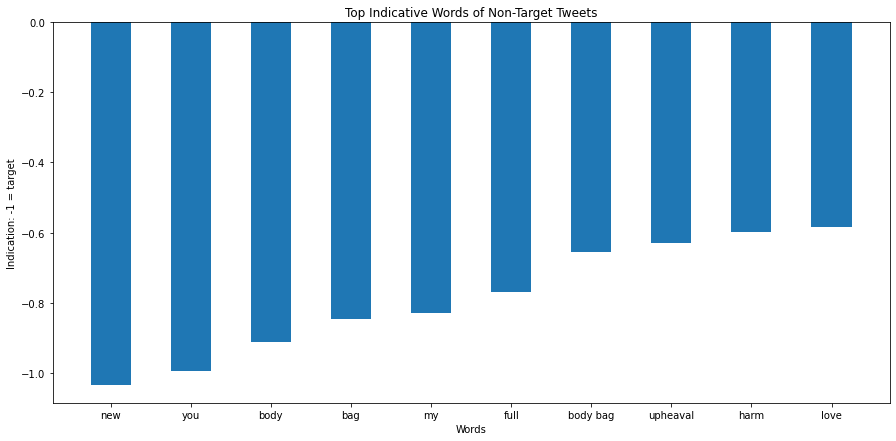

In [105]:
plt.figure(figsize=(15,7))
x = list(non_target['Col'])
value = list(non_target['Coef'])
plt.bar(x, value,width=.5)
plt.title('Top Indicative Words of Non-Target Tweets');
plt.xlabel('Words')
plt.ylabel('Indication: -1 = target')
plt.show();

In [106]:
disaster = predictor_df.sort_values(by='Coef',ascending=False).head(10)

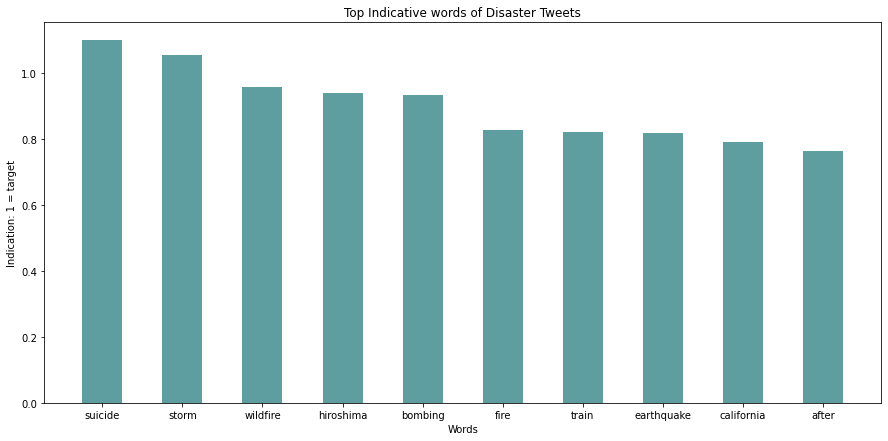

In [107]:
plt.figure(figsize=(15,7))
x = list(disaster['Col'])
value = list(disaster['Coef'])
plt.bar(x, value,width=.5, color='cadetblue')
plt.title('Top Indicative words of Disaster Tweets');
plt.xlabel('Words')
plt.ylabel('Indication: 1 = target')
plt.show();

Kaggle submission

In [108]:
test

,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,aba,...,youtube playlist,youtube video,youtube video from,youve,yr,yr old,yr old pkk,zone,zone war,zone war zone
0,6,6,2,0,4.833333,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,9,2,0,6.222222,64,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,19,10,0,4.105263,96,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,4,0,0,9.250000,40,3,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,8,2,0,4.750000,45,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,8,7,0,0,6.000000,55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3259,23,22,7,0,5.086957,139,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3260,6,6,1,1,8.333333,55,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3261,7,7,0,1,8.428571,65,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
X_train

,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,aba,...,youtube playlist,youtube video,youtube video from,youve,yr,yr old,yr old pkk,zone,zone war,zone war zone
0,24,23,12,0,4.583333,133,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14,13,5,1,8.714286,135,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,17,3,0,7.000000,135,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,14,2,2,8.571429,133,21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,9,4,0,4.900000,58,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5704,15,14,6,0,4.266667,78,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5705,14,14,1,1,5.857143,95,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5706,16,14,4,0,4.937500,94,10,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5707,20,20,7,1,5.450000,128,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
kaggle_sub = lr.predict(test)

In [111]:
submission = pd.DataFrame(data={'target':kaggle_sub})
final = pd.concat([test_id,submission],axis=1,)

In [112]:
final.columns

Index(['id', 'target'], dtype='object')

In [113]:
final.to_csv('datasets/submission.csv', index=False)

78% accuracy (save to conclude that our model has about 80% overall accuracy)

### Conclusion

Overall all the models have roughly 80% accuracy after the texts have been preprocessed. However, the logistic Regression model was able to correctly identify around 74% of all of the disaster tweets which is the highest of all the models. This model associate topic words such as, Suicide, Storm, Wildfire, Hiroshima, Bombing, and Fire with disaster tweets and descriptive words like New, You, Body, Bag, My, and Full with other types of tweets.